In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
from transformers import AutoModel, AutoConfig
from torch.utils.data import TensorDataset, DataLoader
from BESTRq_classes.conformer import ConformerEncoder
from BESTRq_classes.BESTRq import BestRqFramework, RandomProjectionQuantizer

In [2]:
###### Set the device to use Apple M1 GPU #######
device = th.device('mps')

In [24]:
def pretrain(trainloader, validloader, model, epochs=10, lr=1e-3, device = 'cpu'):

    optimizer = optim.Adam(model.encoder.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    train_losses = []  # Pour sauvegarder la loss à chaque époch
    valid_losses = []  # Pour sauvegarder la loss de validation à chaque époch
    valid_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch
    train_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch

    # Iterate over epochs
    for epoch in tqdm(range(epochs)):
        epoch_train_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        model.train()
        for inputs, _ in trainloader:
            optimizer.zero_grad()
            inputs = inputs.view(1, -1, 600).to(device)
            encoder_outs, labels = model(inputs, masking = True)
            loss = loss_function(encoder_outs, labels.view(-1))
            loss.backward()
            optimizer.step()
            # Compute accuracy
            predicted = th.argmax(encoder_outs, dim=1)
            total += labels.size(1)
            correct += (predicted == labels.view_as(predicted)).sum().item()
            epoch_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        # Calculate validation accuracy
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        with th.no_grad():
            epoch_valid_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in validloader:
                inputs = inputs.view(1, -1, 600).to(device)
                encoder_outs, labels = model(inputs, masking = False)
                loss = loss_function(encoder_outs, labels.view(-1))
                epoch_valid_loss += loss.item()

                # Compute accuracy
                predicted = th.argmax(encoder_outs, dim=1)
                total += labels.size(1)
                correct += (predicted == labels.view_as(predicted)).sum().item()

            # Calculate average validation loss for the epoch
            avg_valid_loss = epoch_valid_loss / len(validloader)
            valid_losses.append(avg_valid_loss)

            # Calculate validation accuracy
            valid_accuracy = correct / total
            valid_accuracies.append(valid_accuracy)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {valid_accuracy}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [4]:
filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
input_dim = xtrain[0].shape
input_dim[0], xtrain.shape

(600, torch.Size([175995, 600]))

In [5]:
class GRUPredictor(nn.Module):
    """GRUPredictor is a recurrent model. It takes as input a vector and predict
    the next one given past observations."""
    def __init__(self, input_dim=600, hidden_dim=50, nstack = 3, dropout=0):
        super(GRUPredictor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nstack = nstack
        self.dropout = dropout
        self.gru = nn.GRU(input_size=input_dim, hidden_size = hidden_dim,  num_layers = nstack)
        self.linear = nn.Linear(in_features = hidden_dim, out_features = 200)
        self.drop = nn.Dropout(p = dropout)
    def init_hidden(self, bsz):
        # This function is given: understand it.
        self.h = th.zeros(self.nstack, bsz, self.hidden_dim)

    def forward(self, inputs, h0=None):
        if h0 == None:
          h0 = self.init_hidden(inputs.shape[0])
        hidden, h0 = self.gru(inputs, h0)
        out = self.drop(hidden)
        out = self.linear(hidden)
        return out

In [6]:
class AttentionLSTM(nn.Module):
    def __init__(self, input_dim=600, hidden_dim=100, nstack=3, dropout=0, codebook_size = 50):
        super(AttentionLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nstack = nstack
        self.dropout = dropout

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=nstack)

        # Linear layers for attention
        self.attention_linear = nn.Linear(hidden_dim, 1)
        self.context_linear = nn.Linear(hidden_dim, hidden_dim)

        # Final linear layer
        self.linear = nn.Linear(hidden_dim, codebook_size)

        # Dropout layer
        self.drop = nn.Dropout(p=dropout)

    def init_hidden(self, bsz):
        # Initialize hidden state for LSTM
        return (th.zeros(self.nstack, bsz, self.hidden_dim),
            th.zeros(self.nstack, bsz, self.hidden_dim))


    def forward(self, inputs, h0=None):
        if h0 is None:
            (h0, c0) = self.init_hidden(inputs.size(1))  # Use size(1) to get the batch size

        h0, c0 = h0.to(device), c0.to(device)

        # Transpose inputs to match the expected dimensions
        inputs = inputs

        # LSTM forward pass
        lstm_output, _ = self.lstm(inputs, (h0, c0))

        # Compute attention weights
        attention_weights = F.softmax(self.attention_linear(lstm_output), dim=0)

        # Apply attention to LSTM output
        attention_applied = th.sum(attention_weights * lstm_output, dim=0)

        # Compute context vector
        context = self.context_linear(attention_applied)

        # Apply dropout
        out = self.drop(context)

        #Linear layer
        out = self.linear(out)

        #Softmax layer
        out = F.softmax(out, dim= 1)

        return out


In [7]:
device = 'cpu'
tmp = RandomProjectionQuantizer(input_dim= 600, quantizer_dim= 100, codebook_size= 70,random_state= 2673834267383, device = device)
input_size = (175995, 600)
mask_time_indices = th.ones(input_size[0], input_size[1], dtype=th.bool, device= device).to(device)
mask_time_indices = mask_time_indices.view(-1, input_size[1]).unsqueeze(0)
xtrain_batched = xtrain.unsqueeze(0).to(device)
results  = tmp(xtrain_batched)
results.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])

Text(0.5, 1.0, 'Visualisation du masque')

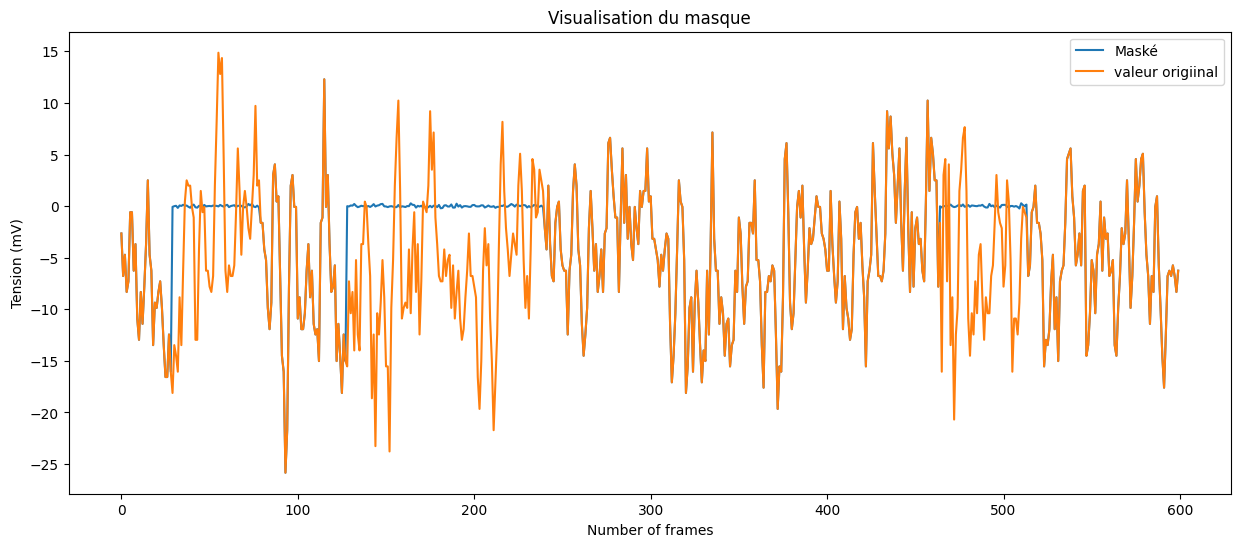

In [8]:
#Viz of the mask
model = BestRqFramework(encoder= AttentionLSTM(dropout = 0.1, hidden_dim = 150),
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=600,
                        encoder_hidden_size=20,
                        num_code_books=50,
                        mask_time= 50,
                        stride_time=1,
                        random_state=42,
                        mask_prob=1,
                        batch_size=200)

inputs = xtrain[:200].to(device).view(-1, 200, 600)

masked_values,_ = model.masking(inputs)


plt.figure(figsize=(15,6))
for i in range(1):
    plt.plot(masked_values[0,i,:].cpu().detach().numpy(), label = 'Maské')
    plt.plot(inputs[0, i ,:].cpu().detach().numpy(), label ='valeur origiinal')
plt.legend()
plt.xlabel('Number of frames')
plt.ylabel('Tension (mV)')
plt.title('Visualisation du masque')

In [5]:
conformer_model = ConformerEncoder(input_size = 600, num_blocks = 3, kernel_size = 3, num_heads = 4).to(device)

In [32]:
device = th.device('mps')

model = BestRqFramework(encoder= AttentionLSTM(dropout= 0.1, hidden_dim = 50, codebook_size= 70),
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=600,
                        encoder_hidden_size=200,
                        num_code_books=70,
                        mask_time= 50,
                        stride_time=1,
                        random_state=42,
                        mask_prob=0.2,
                        batch_size=200,
                        device = device)


inputs = xtrain[:200].to(device).view(-1, 200, 600)
    # `(batch size)` Number of available time steps per batch
input_lengths = th.tensor([200, 871, 389, 487]).to(device)

input_values, idx = model(inputs, masking = False)

input_values, idx

(tensor([[0.0141, 0.0158, 0.0161,  ..., 0.0121, 0.0145, 0.0144],
         [0.0142, 0.0163, 0.0160,  ..., 0.0124, 0.0150, 0.0146],
         [0.0140, 0.0158, 0.0164,  ..., 0.0120, 0.0147, 0.0144],
         ...,
         [0.0139, 0.0160, 0.0163,  ..., 0.0118, 0.0147, 0.0142],
         [0.0142, 0.0157, 0.0164,  ..., 0.0120, 0.0147, 0.0145],
         [0.0139, 0.0160, 0.0162,  ..., 0.0125, 0.0143, 0.0148]],
        device='mps:0', grad_fn=<SoftmaxBackward0>),
 tensor([[14, 44,  1,  9, 64, 69,  4, 13, 58, 67, 57, 33, 14,  4, 41, 36,  0, 68,
          48, 30, 14, 17, 20,  4, 14, 34, 14, 35, 58, 41, 14, 34, 54, 57, 14, 60,
          14, 34, 60, 47,  4, 11, 35, 44, 28,  8, 43, 68, 24, 69, 35, 68, 40, 68,
          65, 33, 65, 56,  4,  6, 66,  4,  4, 65, 37, 57, 34,  9, 36, 24,  1,  4,
          14, 57, 41, 18, 34, 36, 58, 14, 67, 57, 10, 51, 49, 20, 36, 67, 14, 34,
          14, 13, 44, 65,  4, 65, 65, 24, 14, 34, 68, 65, 13, 34,  4, 48, 64, 69,
           1, 28, 61,  4, 67, 10, 69, 41, 34, 14, 

Tried doing with hidden_dim = 200, mask_prob = 0.3, epochs = 100 but signs of overfitting appeared for about 30 epochs

In [33]:
dataset_t = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(dataset_t, batch_size= 400, shuffle=True)
dataset_v = TensorDataset(xvalid, yvalid)
valid_loader = DataLoader(dataset_v, batch_size= 400, shuffle=True)
train_losses, valid_losses, train_accuracies, valid_accuracies = pretrain(trainloader= train_loader, validloader= valid_loader, model = model, epochs= 200, device = device, lr = 1e-3)

  0%|          | 1/200 [00:28<1:34:02, 28.35s/it]

Epoch 1/200, Train Loss: 4.12465500831604, Validation Loss: 4.061504286162707, Training Accuracy: 0.14650416205005823, Validation Accuracy: 0.2100184766988298


  1%|          | 2/200 [00:54<1:29:00, 26.97s/it]

Epoch 2/200, Train Loss: 4.04161842844703, Validation Loss: 4.0236965539504075, Training Accuracy: 0.2309838347680332, Validation Accuracy: 0.24851159926093205


  1%|          | 2/200 [00:57<1:35:22, 28.90s/it]


KeyboardInterrupt: 

Text(0.5, 0.98, 'Attention-LSTM')

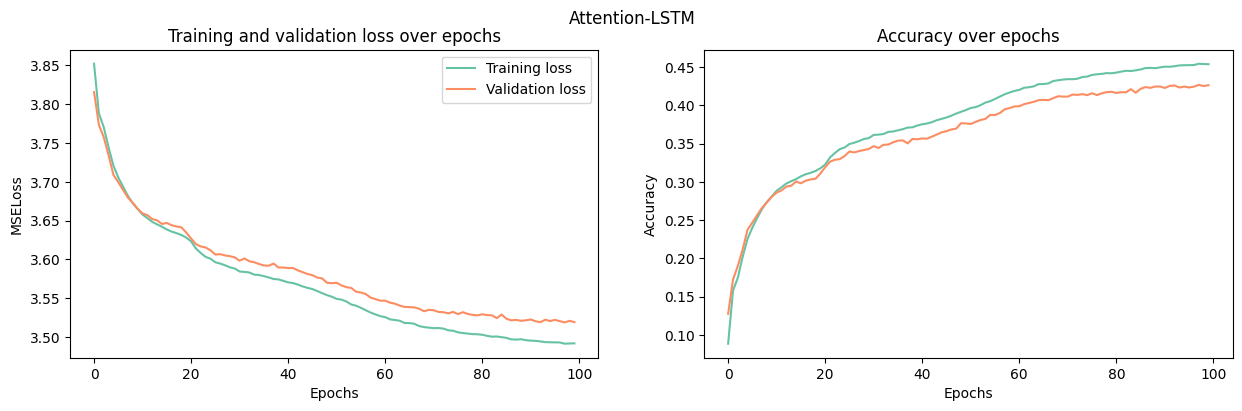

In [30]:
sns.set_palette("Set2")
fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(train_losses, label = 'Training loss')
ax[0].plot(valid_losses, label = 'Validation loss')
ax[1].plot(train_accuracies, label ='Training Accuracy')
ax[1].plot(valid_accuracies, label ='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Training and validation loss over epochs')
ax[1].set_title('Accuracy over epochs')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('MSELoss')
ax[1].set_ylabel('Accuracy')
fig.suptitle('Attention-LSTM')